In [35]:
#using word2vec

In [36]:
import pandas as pd

anger_train = pd.read_csv('./train_dataset/anger_train.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])
joy_train = pd.read_csv('./train_dataset/joy_train.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])
fear_train = pd.read_csv('./train_dataset/fear_train.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])
sadness_train = pd.read_csv('./train_dataset/sadness_train.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])

# Concatenate the dataframes
train_data = pd.concat([anger_train, joy_train, fear_train, sadness_train], ignore_index=True)

# Display the first few rows of the merged dataframe
print(train_data.head())

      id                                               text emotion  intensity
0  10000  How the fu*k! Who the heck! moved my fridge!.....   anger      0.938
1  10001  So my Indian Uber driver just called someone t...   anger      0.896
2  10002  @DPD_UK I asked for my parcel to be delivered ...   anger      0.896
3  10003  so ef whichever butt wipe pulled the fire alar...   anger      0.896
4  10004  Don't join @BTCare they put the phone down on ...   anger      0.896


In [37]:
# Display the count of each emotion in the merged dataframe
emotion_counts = train_data['emotion'].value_counts()
print(emotion_counts)

emotion
fear       1147
anger       857
joy         823
sadness     786
Name: count, dtype: int64


In [26]:
# Load the testing files
anger_test = pd.read_csv('./test_dataset/anger_test.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])
joy_test = pd.read_csv('./test_dataset/joy_test.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])
fear_test = pd.read_csv('./test_dataset/fear_test.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])
sadness_test = pd.read_csv('./test_dataset/sadness_test.txt', delimiter='\t', header=None, names=['id', 'text', 'emotion', 'intensity'])

# Concatenate the testing dataframes
test_data = pd.concat([anger_test, joy_test, fear_test, sadness_test], ignore_index=True)

# Display the first few rows of the testing dataframe
print(test_data.head())

      id                                               text emotion  intensity
0  10941  At the point today where if someone says somet...   anger      0.319
1  10942  @CorningFootball  IT'S GAME DAY!!!!      T MIN...   anger      0.144
2  10943  This game has pissed me off more than any othe...   anger      0.898
3  10944  @spamvicious I've just found out it's Candice ...   anger      0.271
4  10945  @moocowward @mrsajhargreaves @Melly77 @GaryBar...   anger      0.646


In [27]:
# Display the count of each emotion in the merged dataframe
emotion_counts = test_data['emotion'].value_counts()
print(emotion_counts)

emotion
fear       995
anger      760
joy        714
sadness    673
Name: count, dtype: int64


In [28]:
import re

# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply the clean_text function to the text column
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Display the first few rows of the cleaned dataframe
train_data.head(3),test_data.head(3)

(      id                                               text emotion  \
 0  10000  How the fu*k! Who the heck! moved my fridge!.....   anger   
 1  10001  So my Indian Uber driver just called someone t...   anger   
 2  10002  @DPD_UK I asked for my parcel to be delivered ...   anger   
 
    intensity                                       cleaned_text  
 0      0.938  how the fuk who the heck moved my fridge shoul...  
 1      0.896  so my indian uber driver just called someone t...  
 2      0.896   i asked for my parcel to be delivered to a pi...  ,
       id                                               text emotion  \
 0  10941  At the point today where if someone says somet...   anger   
 1  10942  @CorningFootball  IT'S GAME DAY!!!!      T MIN...   anger   
 2  10943  This game has pissed me off more than any othe...   anger   
 
    intensity                                       cleaned_text  
 0      0.319  at the point today where if someone says somet...  
 1      0.144    

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming train_data['text'] and test_data['text'] contain the text data

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_text'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['cleaned_text'])

# Pad the sequences to ensure they are all the same length
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [30]:
import gensim.downloader as api

# Load pre-trained Word2Vec model (e.g., Google News vectors)
word2vec_model = api.load('word2vec-google-news-300')


In [31]:
 import numpy as np

# Define the embedding dimension
embedding_dim = 300

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Define the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_len, 
              trainable=False),
    Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=1, activation='linear')  # Assuming regression output
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Convert intensity labels to numpy array
y_train = train_data['intensity'].values
y_test = test_data['intensity'].values

# Train the model
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_test_pad, y_test))

# Save the model in Keras format
model.save('emotion_intensity_model_with_word2vec.keras')


C:\Users\PC User's\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58m

In [33]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('emotion_intensity_model_with_word2vec.keras')

# Evaluate the model on test data
test_loss, test_mse = loaded_model.evaluate(X_test_pad, y_test, verbose=2)

# Print evaluation results
print(f'Test Loss: {test_loss}')
print(f'Test MSE: {test_mse}')


99/99 - 3s - 30ms/step - loss: 0.0355 - mse: 0.0355
Test Loss: 0.0354742594063282
Test MSE: 0.0354742594063282


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


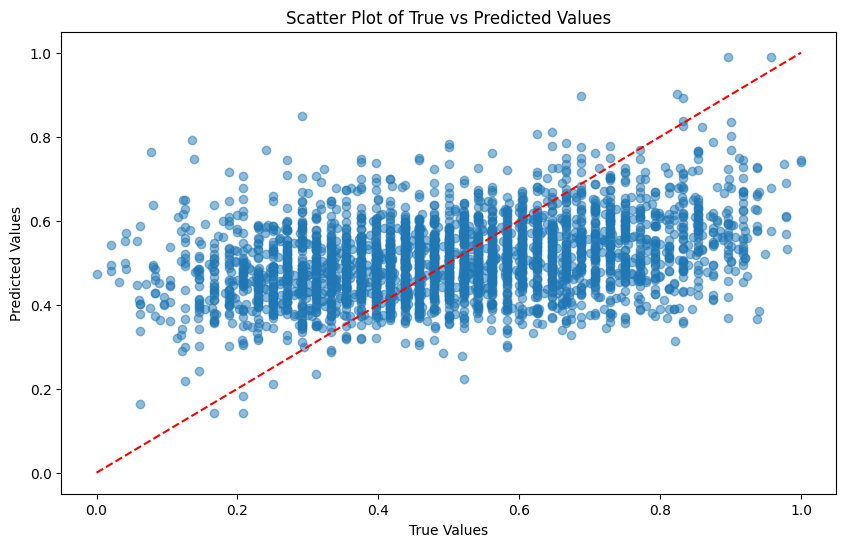

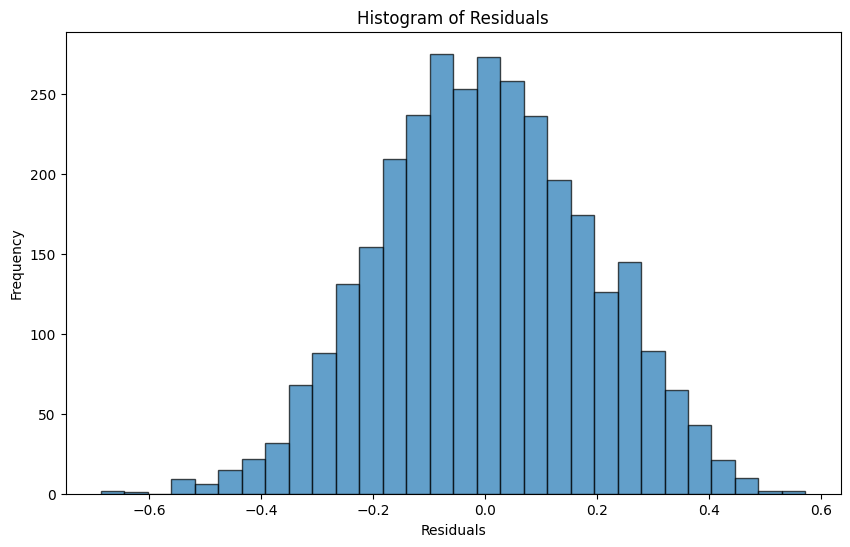

In [34]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = loaded_model.predict(X_test_pad)

# Calculate residuals
residuals = y_test - y_pred.flatten()

# Scatter plot between predicted and true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

# Residual histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
